In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hydrotools.nwis_client.iv import IVDataService
import datetime
import matplotlib.dates as mdates
import matplotlib.units as munits
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter
%matplotlib widget

In [2]:
client = IVDataService()
streamflow = client.get(
    sites="02146470",
    startDT="2019-10-01",
    endDT="2020-09-30"
    )
rainfall = client.get(
    sites="351104080521845",
    parameterCd="00045",
    startDT="2019-10-01",
    endDT="2020-09-30"
    )

In [3]:
catchment_area = 2.63 # square miles
streamflow = streamflow[["value_time", "value"]].groupby(pd.Grouper(key="value_time", freq="5min")).first()
streamflow = streamflow.div(7744*catchment_area).resample("1H").sum().reset_index()

In [4]:
rainfall = rainfall[["value_time", "value"]].groupby(pd.Grouper(key="value_time", freq="1H")).sum().reset_index()

In [5]:
def plot_hydrograph(streamflow, precipitation):
    fig, (px, qx) = plt.subplots(ncols=1, nrows=2, figsize=(6.4, 3.6), sharex=True, dpi=75,
        gridspec_kw={"height_ratios": [1, 4], "hspace": 0}
        )
    px.plot(precipitation["value_time"], precipitation["value"], "-", color="C4")
    px.set_ylim(0.0, np.round(rainfall["value"].max(), 1) + 0.1)
    px.yaxis.set_label_position("right")
    px.yaxis.tick_right()
    px.invert_yaxis()
    px.set_ylabel("Precipitation ($inch\\enspace h^{-1}$)", loc="top")

    qx.semilogy(streamflow["value_time"], streamflow["value"], "-", color="C0")
    qx.set_xlim(streamflow["value_time"].min(), streamflow["value_time"].max())
    qx.set_xlabel("DateTime (UTC)")
    qx.set_ylabel("Discharge per unit area ($inch\\enspace h^{-1}$)")

    px.spines[["bottom"]].set_visible(False)
    qx.spines[["top"]].set_visible(False)
    fig.tight_layout()
    fig.canvas.toolbar_position = "top"
    fig.canvas.header_visible = False
    fig.canvas.resizable = False
    return fig, (px, qx)

In [6]:
with plt.ioff():
    fig, _ = plot_hydrograph(streamflow, rainfall)

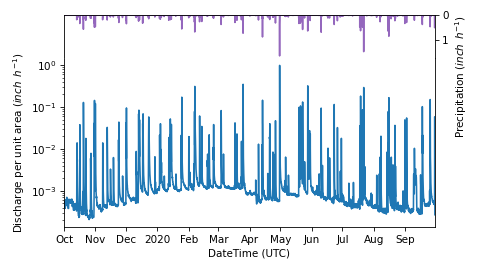

In [7]:
plt.show()

In [8]:
streamflow["value"].sum() / rainfall["value"].sum()

0.45515147